In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv("data/test.csv")
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


**Variable Notes**

- pclass: A proxy for socio-economic status (SES)
    - 1st = Upper
    - 2nd = Middle
    - 3rd = Lower
- age: Age is fractional if less than 1. If the age is estimated, is it in the form of xx.5
- sibsp: The dataset defines family relations in this way...
    - Sibling = brother, sister, stepbrother, stepsister
    - Spouse = husband, wife (mistresses and fiancés were ignored)
- parch: The dataset defines family relations in this way...
    - Parent = mother, father
    - Child = daughter, son, stepdaughter, stepson
    - Some children travelled only with a nanny, therefore parch=0 for them.



In [3]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer


def clean_data(data):

    # Use MICE algorithm to impute Age and Fare Data
    imputer = IterativeImputer(random_state=0, max_iter=20) # Define imputer
    imputer.fit(data[['Age','Fare']]) # impute
    df_imputed = imputer.transform(data[['Age','Fare']])
    data[['Age','Fare']] = df_imputed 

    
    data.loc[data['Sex'] == 'male', 'Sex'] = 0
    data.loc[data['Sex'] =='female',  'Sex'] = 1

    # Impute Embarked with majority class
    N = data['Embarked'].isnull().sum()
    data['Embarked'] = data['Embarked'].fillna(N)
    data.loc[data["Embarked"] == 'S', 'Embarked'] = 0
    data.loc[data['Embarked'] == 'C', 'Embarked'] = 1
    data.loc[data['Embarked'] == 'Q', 'Embarked'] = 2

    data.drop(columns=['Cabin'],inplace=True)


In [4]:
def write_prediction(prediction, name):
    PassengerId = np.array(test['PassengerId']).astype(int)
    solution = pd.DataFrame(prediction, PassengerId, columns = ['Survived'])
    solution.to_csv(name, index_label = ['PassengerId'])

In [5]:
clean_data(train)
clean_data(test)

In [6]:
train['SibSp'].unique()

array([1, 0, 3, 4, 2, 5, 8])

/Users/osianshelley/opt/anaconda3/envs/statisticalLearning/lib/python3.11/site-packages/seaborn/axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


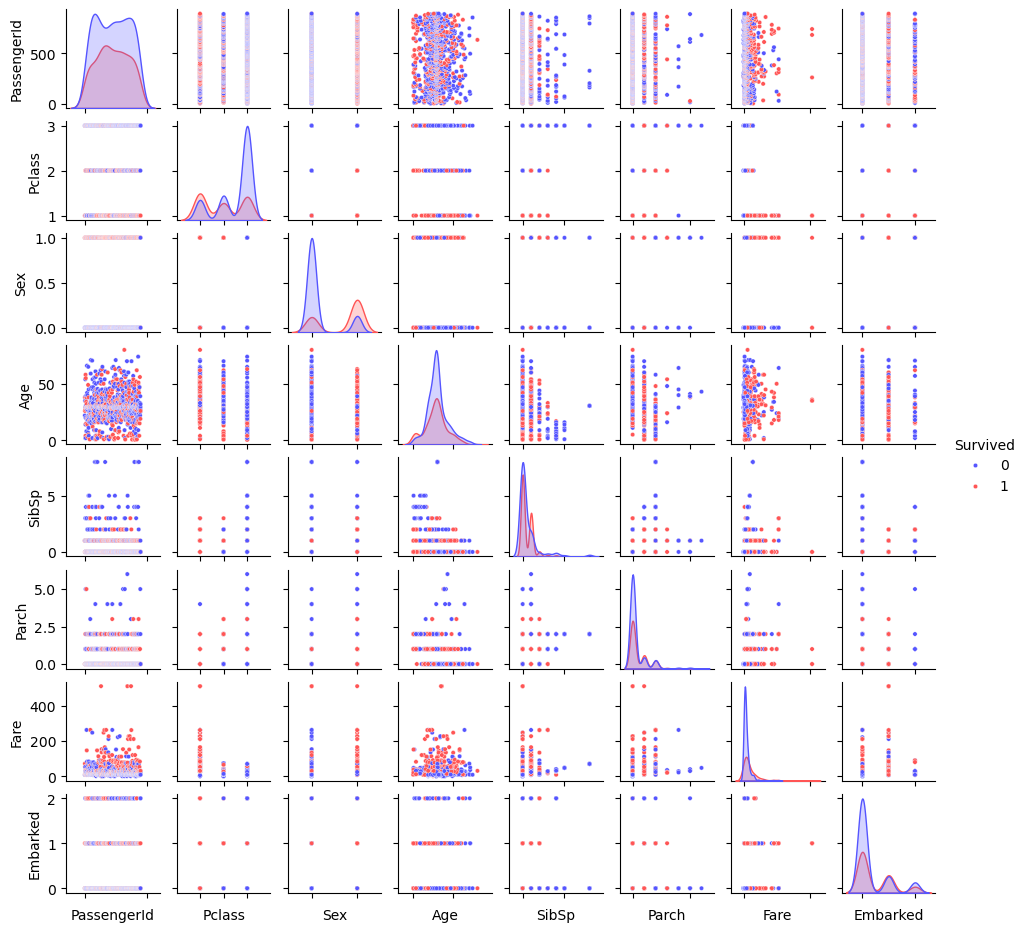

In [7]:
g = sns.pairplot(data=train, hue='Survived', palette = 'seismic',
                 height=1.2,diag_kind = 'kde',diag_kws=dict(fill=True),plot_kws=dict(s=10) )
g.set(xticklabels=[])

In [67]:
all_data=[train,test]
for dataset in all_data:
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

In [68]:
# Define function to extract titles from passenger names
import re

def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""
# Create a new feature Title, containing the titles of passenger names
for dataset in all_data:
    dataset['Title'] = dataset['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
for dataset in all_data:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 
                                                 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

In [69]:

## create Range for age features
for dataset in all_data:
    dataset['Age_Range'] = pd.cut(dataset['Age'], bins=[0,12,20,40,120], labels=['Children','Teenage','Adult','Elder'])

In [70]:
## create RAnge for fare features
for dataset in all_data:
    dataset['Fare_Range'] = pd.cut(dataset['Fare'], bins=[0,7.91,14.45,31,120], labels=['Low_fare','median_fare',
                                                                                      'Average_fare','high_fare'])

In [71]:
#Avoiding dataloss making a copy of both DataSet start working for copy of dataset
traindf=train
testdf=test

In [72]:
all_dat=[traindf,testdf]

In [73]:


for dataset in all_dat:
    drop_column = ['Age','Fare','Name','Ticket']
    dataset.drop(drop_column, axis=1, inplace = True)

In [74]:


#Removing the passenger id from trainning set 
drop_column = ['PassengerId']
traindf.drop(drop_column, axis=1, inplace = True)



In [75]:
all_dat[1]


,PassengerId,Pclass,Sex,SibSp,Parch,Embarked,FamilySize,Title,Age_Range,Fare_Range
0,892,3,0,0,0,2,1,Mr,Adult,Low_fare
1,893,3,1,1,0,0,2,Mrs,Elder,Low_fare
2,894,2,0,0,0,2,1,Mr,Elder,median_fare
3,895,3,0,0,0,0,1,Mr,Adult,median_fare
4,896,3,1,1,1,0,3,Mrs,Adult,median_fare
...,...,...,...,...,...,...,...,...,...,...
413,1305,3,0,0,0,0,1,Mr,Adult,median_fare
414,1306,1,1,0,0,1,1,Rare,Adult,high_fare
415,1307,3,0,0,0,0,1,Mr,Adult,Low_fare
416,1308,3,0,0,0,0,1,Mr,Adult,median_fare


In [76]:
testdf.head(5)

,PassengerId,Pclass,Sex,SibSp,Parch,Embarked,FamilySize,Title,Age_Range,Fare_Range
0,892,3,0,0,0,2,1,Mr,Adult,Low_fare
1,893,3,1,1,0,0,2,Mrs,Elder,Low_fare
2,894,2,0,0,0,2,1,Mr,Elder,median_fare
3,895,3,0,0,0,0,1,Mr,Adult,median_fare
4,896,3,1,1,1,0,3,Mrs,Adult,median_fare


In [77]:
#Adding the extra feataure in Train data set
traindf = pd.get_dummies(traindf, columns = ["Sex","Title","Age_Range","Embarked","Fare_Range"],
                             prefix=["Sex","Title","Age_type","Em_type","Fare_type"])

In [78]:
traindf.head()

,Survived,Pclass,SibSp,Parch,FamilySize,Sex_0,Sex_1,Title_Master,Title_Miss,Title_Mr,...,Age_type_Teenage,Age_type_Adult,Age_type_Elder,Em_type_0,Em_type_1,Em_type_2,Fare_type_Low_fare,Fare_type_median_fare,Fare_type_Average_fare,Fare_type_high_fare
0,0,3,1,0,2,True,False,False,False,True,...,False,True,False,True,False,False,True,False,False,False
1,1,1,1,0,2,False,True,False,False,False,...,False,True,False,False,True,False,False,False,False,True
2,1,3,0,0,1,False,True,False,True,False,...,False,True,False,True,False,False,False,True,False,False
3,1,1,1,0,2,False,True,False,False,False,...,False,True,False,True,False,False,False,False,False,True
4,0,3,0,0,1,True,False,False,False,True,...,False,True,False,True,False,False,False,True,False,False


In [79]:
print(traindf.isnull().sum())

Survived                  0
Pclass                    0
SibSp                     0
Parch                     0
FamilySize                0
Sex_0                     0
Sex_1                     0
Title_Master              0
Title_Miss                0
Title_Mr                  0
Title_Mrs                 0
Title_Rare                0
Age_type_Children         0
Age_type_Teenage          0
Age_type_Adult            0
Age_type_Elder            0
Em_type_0                 0
Em_type_1                 0
Em_type_2                 0
Fare_type_Low_fare        0
Fare_type_median_fare     0
Fare_type_Average_fare    0
Fare_type_high_fare       0
dtype: int64


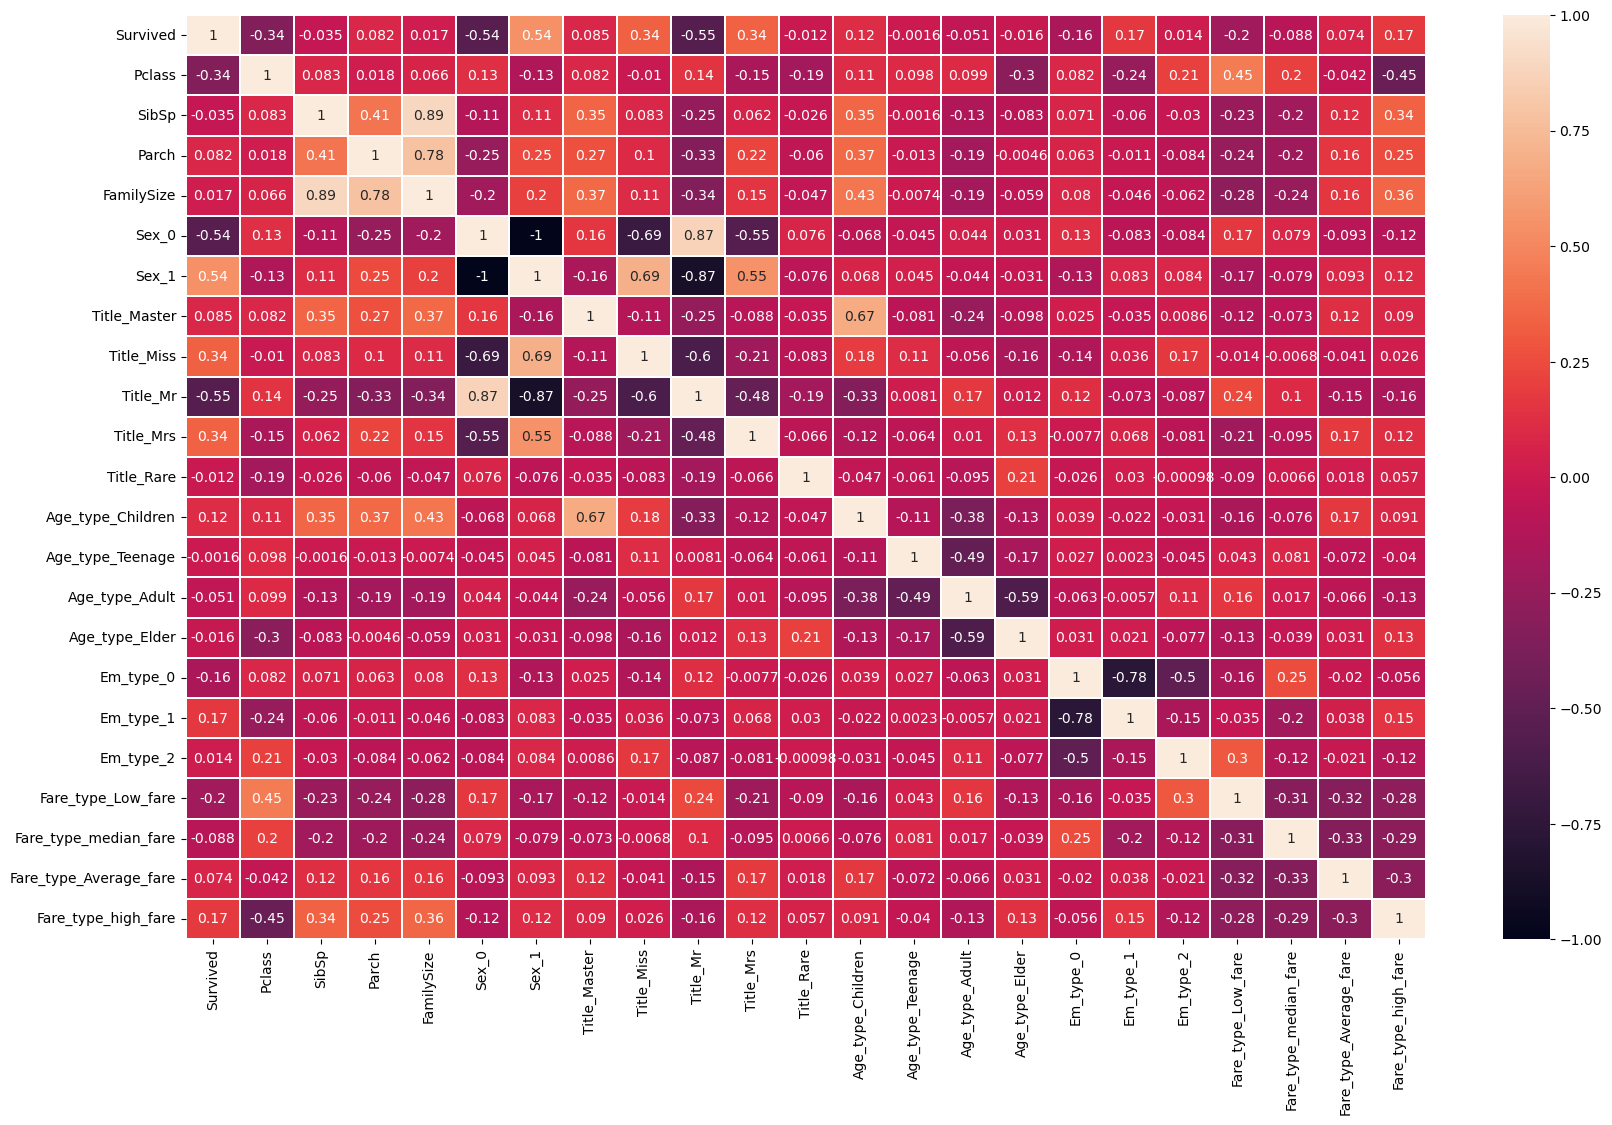

In [80]:
sns.heatmap(traindf.corr(),annot=True,linewidths=0.2)
fig=plt.gcf()
fig.set_size_inches(20,12)
plt.show()

In [81]:
testndf = pd.get_dummies(testdf, columns = ["Sex","Title","Age_Range","Embarked","Fare_Range"],
                             prefix=["Sex","Title","Age_type","Em_type","Fare_type"])

In [82]:
traindf.to_csv('data/processedTrain.csv', index=False)
traindf.head()
testndf.to_csv('data/processedTest.csv', index=False)

In [83]:
import keras

In [84]:
from keras.models import Sequential
from keras.layers import Dense,Dropout

classifier = Sequential()
classifier.add(Dense(activation="relu", input_dim=22, units=11, kernel_initializer="uniform"))
classifier.add(Dense(activation="relu", units=11, kernel_initializer="uniform"))
classifier.add(Dropout(0.5))
classifier.add(Dense(activation="relu", units=11, kernel_initializer="uniform"))
classifier.add(Dropout(0.5))
classifier.add(Dense(activation="relu", units=5, kernel_initializer="uniform"))
classifier.add(Dense(activation="sigmoid", units=1, kernel_initializer="uniform"))
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_5 (Dense)             (None, 11)                253       
                                                                 
 dense_6 (Dense)             (None, 11)                132       
                                                                 
 dropout_2 (Dropout)         (None, 11)                0         
                                                                 
 dense_7 (Dense)             (None, 11)                132       
                                                                 
 dropout_3 (Dropout)         (None, 11)                0         
                                                                 
 dense_8 (Dense)             (None, 5)                 60        
                                                                 
 dense_9 (Dense)             (None, 1)                

In [85]:
history=classifier.fit(features, target, batch_size = 10, epchocs = 100,
    validation_split=0.1,verbose = 1,shuffle=True)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/Users/osianshelley/opt/anaconda3/envs/statisticalLearning/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3508, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/var/folders/pr/17s5kwdj30zgkzxjrjrpr8fm0000gn/T/ipykernel_92671/3898870784.py", line 1, in <module>
    history=classifier.fit(features, target, batch_size = 10, epchocs = 100,
            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/osianshelley/opt/anaconda3/envs/statisticalLearning/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/Users/osianshelley/opt/anaconda3/envs/statisticalLearning/lib/python3.11/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
    filtered_tb = _process_traceback_frames(e.__traceback__)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: M